In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam
from keras import backend as K
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline

Using TensorFlow backend.


In [2]:
datapath = 'F:\PhD\ABSA\Data\OpeNER\OpeNER_TOP.csv'

In [3]:
dataset = pd.read_csv(datapath)

In [4]:
dataset.shape

(4150, 3)

In [5]:
dataset.head()

,TARGET,OTE,POLARITY
0,Hotel,full of Russians and children,Negative
1,evening entertainment,Not suitable for couples without children,Negative
2,evening entertainment,almost nill,Negative
3,evening entertainment,geared for families,Negative
4,The bar staff,make nice comments,Positive


In [6]:
dataset['TOKENS'] = dataset.OTE.apply(lambda x: x.split())
dataset['TLEN'] = dataset.TOKENS.apply(lambda x: len(x))
dataset['CLASS'] = ~dataset.POLARITY.str.contains('Negative')

In [7]:
dataset.head(15)

,TARGET,OTE,POLARITY,TOKENS,TLEN,CLASS
0,Hotel,full of Russians and children,Negative,"[full, of, Russians, and, children]",5,False
1,evening entertainment,Not suitable for couples without children,Negative,"[Not, suitable, for, couples, without, children]",6,False
2,evening entertainment,almost nill,Negative,"[almost, nill]",2,False
3,evening entertainment,geared for families,Negative,"[geared, for, families]",3,False
4,The bar staff,make nice comments,Positive,"[make, nice, comments]",3,True
5,The bar staff,did make an effort to smile,Positive,"[did, make, an, effort, to, smile]",6,True
6,The bar staff,overworked,Negative,[overworked],1,False
7,The bar staff,tired,Negative,[tired],1,False
8,Room,large,Positive,[large],1,True
9,Room,very clean,StrongPositive,"[very, clean]",2,True


In [8]:
def freq_dist(tokens):
    c = Counter()
    for t in tokens:
        c.update(t)
    return c

def w_index(counter, start_idx=3):
    w_idx = {w:i+start_idx for i,(w,c) in enumerate(counter.most_common())}
    return w_idx


def df2feats(df, colname, w_idx):
    data = df[colname].apply(lambda x: [w_idx[w] for w in x]).values
    return data


def train_test(data, test_per=0.25):
    split = int(data.shape[0]*(1-0.25))
    
    if len(data.shape) > 1:
        train = data[:split,:]
        test = data[split:,:]
    else:
        train = data[:split]
        test = data[split:]
    
    return train,test

In [9]:
c = freq_dist(dataset.TOKENS)

In [10]:
c.most_common()[-10:]

[('climbing', 1),
 ('Seven', 1),
 ('tube', 1),
 ('prices', 1),
 ('packing', 1),
 ('age', 1),
 ('persons', 1),
 ('drinks', 1),
 ('overcooked', 1),
 ('quit', 1)]

In [11]:
w_idx = w_index(c, start_idx=1)

In [12]:
data = df2feats(dataset, 'TOKENS', w_idx)
data

array([[142, 9, 777, 23, 239], [113, 1422, 17, 1770, 256, 239],
       [504, 1883], ..., [641], [335, 243, 853], [437]], dtype=object)

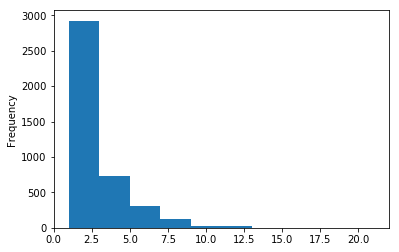

In [13]:
dataset.TLEN.plot('hist')

In [14]:
data = sequence.pad_sequences(data, maxlen=10).astype('float32')
print(data.shape)
data

(4150, 10)


array([[    0.,     0.,     0., ...,   777.,    23.,   239.],
       [    0.,     0.,     0., ...,  1770.,   256.,   239.],
       [    0.,     0.,     0., ...,     0.,   504.,  1883.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,   641.],
       [    0.,     0.,     0., ...,   335.,   243.,   853.],
       [    0.,     0.,     0., ...,     0.,     0.,   437.]], dtype=float32)

In [15]:
labels = dataset.CLASS.values.astype('float32')
print(labels.shape)
labels

(4150,)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [16]:
X_train,X_test = train_test(data)
y_train,y_test = train_test(labels)

In [17]:
X_train.shape

(3112, 10)

In [18]:
y_train.shape

(3112,)

In [19]:
X_test.shape

(1038, 10)

In [20]:
y_test.shape

(1038,)

In [21]:
len(w_idx) #Vocab

1964

In [22]:
max(w_idx.values())

1964

In [23]:
config = {'embedding_size': 200, 
          'vocab': 1964,
          'time_steps': 10,
          'drop_out': 0.2,
          'LSTM_cell': 64,
          'learning_rate': 0.001,
          'decay': 0.0,
          'batch_size': 32,
          'epochs': 15
         }

In [24]:
adam = Adam(lr=config['learning_rate'], decay=config['decay'])
model = Sequential()
model.add(Embedding(config['vocab']+2, config['embedding_size'], input_length=config['time_steps'], mask_zero=True))
model.add(Bidirectional(LSTM(config['LSTM_cell'], dropout=config['drop_out'], recurrent_dropout=config['drop_out'])))
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.layers

In [26]:
model.layers[0].input

<tf.Tensor 'embedding_1_input:0' shape=(?, 10) dtype=int32>

In [27]:
model.layers[0].output

<tf.Tensor 'embedding_1/Gather:0' shape=(?, 10, 200) dtype=float32>

In [28]:
model.layers[1].input

<tf.Tensor 'embedding_1/Gather:0' shape=(?, 10, 200) dtype=float32>

In [29]:
model.layers[1].output

<tf.Tensor 'bidirectional_1/concat_2:0' shape=(?, 128) dtype=float32>

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [31]:
model.fit(X_train, y_train,
          batch_size=config['batch_size'],
          epochs=config['epochs'],
          validation_data=(X_test, y_test))
loss, acc = model.evaluate(X_test, y_test,
                            batch_size=config['batch_size'])

print('Config:\n', config)
print('Test loss:', loss)
print('Test accuracy:', acc)

Train on 3112 samples, validate on 1038 samples
Epoch 1/15
3112/3112 [==============================] - 14s - loss: 0.4969 - acc: 0.7908 - val_loss: 0.3887 - val_acc: 0.8179
Epoch 2/15
3112/3112 [==============================] - 10s - loss: 0.1991 - acc: 0.9393 - val_loss: 0.3604 - val_acc: 0.8439
Epoch 3/15
3112/3112 [==============================] - 11s - loss: 0.1129 - acc: 0.9640 - val_loss: 0.4351 - val_acc: 0.8237
Epoch 4/15
3112/3112 [==============================] - 11s - loss: 0.0814 - acc: 0.9753 - val_loss: 0.4645 - val_acc: 0.8401
Epoch 5/15
3112/3112 [==============================] - 12s - loss: 0.0676 - acc: 0.9781 - val_loss: 0.5946 - val_acc: 0.8295
Epoch 6/15
3112/3112 [==============================] - 14s - loss: 0.0585 - acc: 0.9817 - val_loss: 0.6512 - val_acc: 0.8179
Epoch 7/15
3112/3112 [==============================] - 11s - loss: 0.0556 - acc: 0.9820 - val_loss: 0.6870 - val_acc: 0.8266
Epoch 8/15
3112/3112 [==============================] - 11s - loss: 0.